In [1]:
from utils import *
from scipy.stats import beta

# set up graphing rc
parameters = {'font.sans-serif': 'Times', 'font.size': 16.0}
plt.rcParams.update(parameters)

#TODO make this work with passed in axis 
def random_beta_sample(n_samples, dist, args, var, ax=None, verbose=False):
    if dist == "beta":
        a, b, spread, start = args
        xs = np.linspace(0, 1, 1000)
        
        if verbose:
            plt.figure() 
            plt.plot(xs, beta.pdf(xs, a, b))

            end = str(start + spread)
            plt.xticks(np.arange(2), ("1", f"{end}"))
            plt.yticks([])
            plt.title(f"PDF over which {var} is being sampled")
        
        return (np.random.beta(a, b, size=(n_samples)) * spread) + start
    
# Taken from Duraiswami et al 2014
duraiswami_data = [0.3636363636, 0.8571428571, 1.083333333, 0.6356589147, 0.7741935484, 0.5, 0.4583333333]

# Taken from Aubele et al 1988
aubele_data = [1.142857143, 1.346153846, 1,  0.5217391304, 1.076923077, 0.7777777778, 0.5, 0.5, 1.055555556, 0.6363636364, 0.6, 1.8, 0.4736842105, 0.1612903226, 0.2272727273, 1.294117647, 0.4, 2.12, 0.4347826087, 2.222222222, 0.4285714286, 1, 0.8, 0.5, 0.875, 1.071428571, 1.176470588, 0.8947368421, 0.8461538462]

# cache J matrices 
cache = {}


# Generate regime diagram with varying density

In [57]:
def calc_design_matrix(n_samples, params, ranges): 
    """
    Accepts model parameters and variables ranges, calculates the 
    design matrix M (n_samples, 2 * n_samples) where M[i, j] is the 
    values of Yih's J calculated with the i'th value of n and 
    j'th value of m. 
    """
    
    N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX = \
        (ranges["N_MIN"], ranges["N_MAX"], ranges["N_MIN2"], ranges["N_MAX2"], ranges["M_MIN"], ranges["M_MAX"])
    
    rho1, rho2, mu2, d1 = params["rho1"], params["rho2"], params["mu2"], params["d1"]
    
    key = (n_samples, N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX, rho1, rho2, mu2, d1)
    
    if key in cache:
        return cache[key]
    
    d2s = np.linspace(N_MIN, N_MAX, n_samples)
    mu1s = np.linspace(M_MAX, M_MIN, n_samples) 

    right_d2s = np.linspace(N_MIN2, N_MAX2, n_samples)

    d2s = np.concatenate([d2s, right_d2s])

    results = np.empty((n_samples, 2 * n_samples))

    for i, d2 in enumerate(d2s):
        for j, mu1 in enumerate(mu1s):
            params["d2"] = d2
            params["mu1"] = mu1
            results[j, i] = yihJ(**params)
    
    cache[key] = results
    return results
            
def plot_phase(ax, results, x_labels, y_labels, locs_x, locs_y, color=None, title=None, sidebar=False, label_y=True):

    if not color:
        color = "OrRd"
    
    im = ax.imshow(results, cmap=color, interpolation="nearest")
    
    if sidebar:
        ax.colorbar()
        
    if label_y:
        ax.set_yticks(locs_y)
        ax.set_yticklabels(y_labels.copy())
        ax.set_ylabel("viscosity contrast, $m \ = \ \mu_2 / \mu_1$")
        
    else:
        ax.set_yticks([0])
        ax.set_yticklabels([""])
        
    ax.set_xticks(locs_x)
    ax.set_xticklabels(x_labels.copy())
    ax.set_xlabel("height ratio, $n \ = \ d_2 / d_1$")

        
    
    if not title:
        title = "Stability of $\it{J}$ wrt $\it{m, n}$"

    ax.set_title(title)
    return im

In [58]:
def create_phase_diagram(params, ranges, ax, title=None, color=None, label_y=True):

    locs_y = np.linspace(0, ranges["N_SAMPLES"], ranges["NUM_LABELS_Y"])
    locs_x = np.linspace(0, 2 * ranges["N_SAMPLES"], ranges["NUM_LABELS_X"])

    y_labels = ranges["Y_LABELS"]
    x_labels = ranges["X_LABELS"]
    results = calc_design_matrix(ranges["N_SAMPLES"], params, ranges)

    modified_results = results
    modified_results[modified_results > 0] = .3
    modified_results[modified_results < 0] = 0

    return plot_phase(ax, modified_results, x_labels, y_labels, locs_x, locs_y, color=color, title=title, label_y=label_y)

# now let's reduce the density of the upper layer



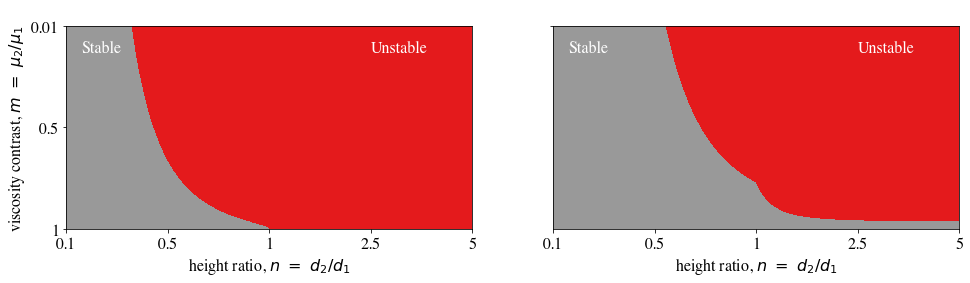

In [62]:
ranges = {
    "N_MIN" : .1,
    "N_MAX" : .999,

    "N_MIN2" : 1,
    "N_MAX2" : 5,

    "M_MIN" : 1.01,
    "M_MAX" : 100,
    
    "NUM_LABELS_Y" : 3,
    "NUM_LABELS_X" : 5,
    
    "X_LABELS" : [.1, .5, 1, 2.5, 5], 

    "N_SAMPLES" : 1000
}

ranges["Y_LABELS"] = [.01, .5, 1]

params = {
    "g" : 1,
    "U0": 1,
    "dP" : 0,

    "verbose" : False,

    "mu2" : 1,
    "rho1" : 1,
    "rho2" : 1,
    "d1" : 1
}

COLOR = "Set1_r"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

title=" "
im1 = create_phase_diagram(params, ranges, ax1, color=COLOR, title=title)

params["rho1"] = .95
ranges["N_MAX2"] = 5
ranges["X_LABELS"] = [.1, .5, 1, 2.5, 5]

title=" "
im2 = create_phase_diagram(params, ranges, ax2, color=COLOR, title=title, label_y=False)
ax1.text(75, 130, "Stable", fontsize=16, color="white")
ax1.text(1500, 130, "Unstable", fontsize=16, color="white")

ax2.text(75, 130, "Stable", fontsize=16, color="white")
ax2.text(1500, 130, "Unstable", fontsize=16, color="white")
#ax2.text(50, 900, "Density difference, r = 1.05", fontsize=16, color="white")

fig.savefig("phase_diagrams/{}".format(COLOR))

# Adding some transparency 
# replace variables with viscosity contrast 
# density difference increasing by 5%
# make a multicolored, sliding line where edits to the phase diagram 

# Generate box plots using field data and model data

In [126]:
np.random.seed(1)

RHO1_MIN = .95
RHO1_MAX = 1

MU1_MIN = 1.0001
MU1_MAX = 100

GRANULARITY = 1000
N_SAMPLES = 10000

params = {}
params["dP"] = 0 
params["g"] = 1
params["U0"] = 1
params["rho2"] = 1
params["d1"] = 1
params["mu2"] = 1
params["verbose"] = False

stable_d2s3 = []

rho1_vals = np.linspace(RHO1_MIN, RHO1_MAX, GRANULARITY)
mu1_vals = np.linspace(MU1_MIN, MU1_MAX, GRANULARITY)

rho1s = np.random.choice(rho1_vals, size=N_SAMPLES)
mu1s =  np.random.choice(mu1_vals, size=N_SAMPLES)


tens = np.ones(N_SAMPLES) * 10
pows = np.random.choice(np.linspace(-1, 1, GRANULARITY), size=N_SAMPLES)

d2s = tens ** pows

for rho1, mu1, d2 in zip(rho1s, mu1s, d2s):
    params["rho1"] = rho1
    params["mu1"] = mu1
    params["d2"] = d2
    if d2 < .1: continue
    if yihJ(**params) <= 0:
        stable_d2s3.append(d2)

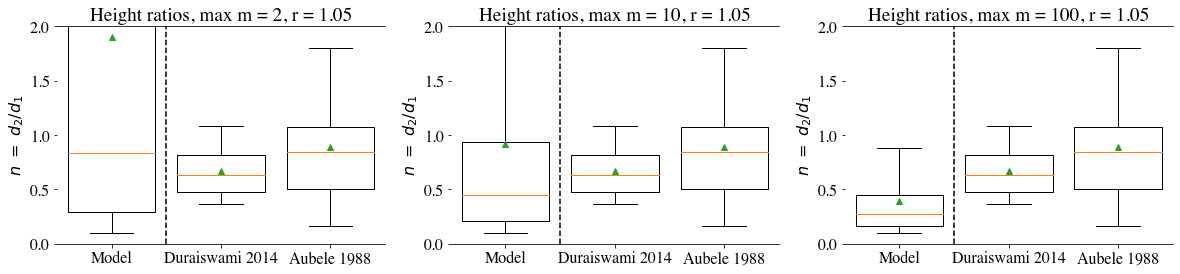

In [128]:
def box_plots(ax, stable_d2s, title=None):

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    labels=["Model", "Duraiswami 2014", "Aubele 1988"]
    ax.boxplot((stable_d2s, duraiswami_data, aubele_data), labels=labels,
                    showfliers=False, widths=.8, showmeans=True)

    if not title:
        title = "Height ratios that result in stability"
        
    ax.set_title(title)
    ax.set_ylabel("$n \ = \ d_2 / d_1$")
    ax.set_ylim((0, 2))
    ax.axvline(1.5, color='black', linestyle='--')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
box_plots(ax1, stable_d2s1, title="Height ratios, max m = 2, r = 1.05")
box_plots(ax2, stable_d2s2, title="Height ratios, max m = 10, r = 1.05")
box_plots(ax3, stable_d2s3, title="Height ratios, max m = 100, r = 1.05")
fig.savefig("box_plots/example_box_plot_varying_max_m_and_r")